In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

In [ ]:
cols = ["area", "per", "circ", "class"]
df = pd.read_csv("total.csv", names=cols)
df = df.iloc[1:].reset_index(drop=True)
df.head()

,area,per,circ,class
0,0.954225,0.710848,0.973007,0
1,0.581988,0.527992,1.031818,0
2,1.132032,0.549399,0.416412,1
3,0.86843,0.655717,1.077616,0
4,0.981333,1.039356,1.006915,0


In [ ]:
df["class"] = (df['class'] == '1').astype(int)

#Train, Validation, Test Datasets

In [ ]:
print(df)

          area       per      circ  class
0     0.954225  0.710848  0.973007      0
1     0.581988  0.527992  1.031818      0
2     1.132032  0.549399  0.416412      1
3      0.86843  0.655717  1.077616      0
4     0.981333  1.039356  1.006915      0
...        ...       ...       ...    ...
2969  0.899801  0.738235  0.926215      0
2970  0.743524  0.565629  0.998565      0
2971  0.823579   0.90708  1.091428      0
2972  1.046875  0.830239  0.816165      0
2973  1.803319  0.942569  0.969374      0

[2974 rows x 4 columns]


In [ ]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
def scale_dataset(dataframe, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [ ]:
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [ ]:
print(len(train[train[:, -1]==0]))
print(len(train[train[:, -1]==1]))

1303
1303


#Neural Network

In [ ]:
  def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentropy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.show()

In [ ]:
nn_model = tf.keras.Sequential([
  tf.keras.layers.Dense(32, activation='relu', input_shape=(3,)),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6455 - loss: 0.6502 - val_accuracy: 0.8521 - val_loss: 0.4696
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8556 - loss: 0.4329 - val_accuracy: 0.8857 - val_loss: 0.3336
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8492 - loss: 0.3883 - val_accuracy: 0.8958 - val_loss: 0.3121
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8794 - loss: 0.3566 - val_accuracy: 0.8975 - val_loss: 0.3166
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8718 - loss: 0.3467 - val_accuracy: 0.9025 - val_loss: 0.2853
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8890 - loss: 0.3178 - val_accuracy: 0.9092 - val_loss: 0.2983
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8941 - loss: 0.2896 - val_accuracy: 0.9395 - val_loss: 0.2482
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9136 - loss: 0.2651 - val_accuracy: 0.9294 - v

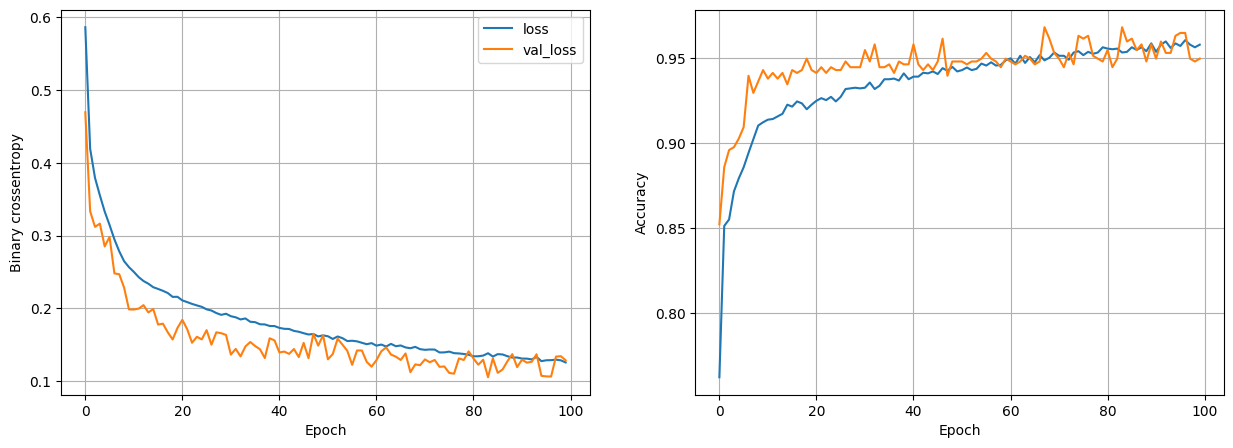

In [ ]:
plot_history(history)

In [ ]:
nn_model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9644 - loss: 0.1385


[0.1424829214811325, 0.9579831957817078]

In [ ]:
y_pred = (nn_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       444
           1       0.88      0.97      0.92       151

    accuracy                           0.96       595
   macro avg       0.93      0.96      0.95       595
weighted avg       0.96      0.96      0.96       595

